### Setup

In [1]:
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import scipy.stats as st

from os import path

In [2]:
# Set matplotlib default styles
mpl_update = {'font.size':16,
              'xtick.labelsize':14,
              'ytick.labelsize':14,
              'figure.figsize':[10.0,5.0], 
              'axes.labelsize':16,
              'axes.labelcolor':'#677385',
              'axes.titlesize':20,
              'lines.color':'#0055A7',
              'lines.linewidth':3,
              'text.color':'#677385'}
mpl.rcParams.update(mpl_update)

# Set seaborn style
sns.set_style('whitegrid')

### Import Data

In [3]:
from os import path

directory = 'data'
file_name = 'NYC_RealEstate_Data.json'

data = pd.read_json(path.join(directory,file_name)).reset_index()

In [4]:
data.head()

,index,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,1466754864000,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
1,1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,1465733967000,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
2,10,1.0,0,0,1460596230000,New to the market! Spacious studio located in ...,York Avenue,[],low,40.7769,6869199,-73.9467,e32475a6134d6d18279946b7b20a0f12,[https://photos.renthop.com/2/6869199_06b2601f...,1950,1661 York Avenue
3,100,1.0,2,e3ea799fc85b5ed5a65cb662e6eebafa,1460523347000,Beautiful 2 Bed apartment in bustling ...,8518 3rd Avenue,[],medium,40.6240,6866364,-74.0312,6f63020874d0bac3287ec5cdf202e270,[https://photos.renthop.com/2/6866364_50f3ac50...,2000,8518 3rd Avenue
4,1000,1.0,1,db572bebbed10ea38c6c47ab41619059,1460433932000,Amazing building in a Prime location! just ste...,W 57 St.,"[Swimming Pool, Roof Deck, Doorman, Elevator, ...",medium,40.7670,6859853,-73.9841,2b14eec3be2c4d669ce5949cf863de6f,[https://photos.renthop.com/2/6859853_db2bbf20...,3275,322 W 57 St.


### Analysis of Price & Rooms

Will calculate the price per room to see if this provides a more distinct relationship with interest level. One would expect this to more accurately reflect the 'value' of a given listing vs. the price itself.

In [5]:
def price_per_room(price, n_bed=0, n_bath=0, bed_only=False, bath_only=False):
    
    # Studios etc. are 'upgraded' to half bedroom
    if n_bed < 1:
        n_bed = 0.5
    
    if bed_only:
        n_rooms = n_bed
    elif bath_only:
        n_rooms = n_bath
    else:
        n_rooms = n_bed + n_bath/2
    
    try:
        ppr = round(price / n_rooms)
    except:
        ppr = pd.np.NaN
    
    return ppr

In [6]:
ppr = data.apply(lambda x: pd.Series({'interest_level': x['interest_level'],
                                      'price': x['price'],
                                      'bedrooms': x['bedrooms'],
                                      'bathrooms':x['bathrooms'], 
                                      'ppr': price_per_room(x['price'], x['bedrooms'], x['bathrooms']),
                                      'ppr_bed': price_per_room(x['price'], x['bedrooms'], x['bathrooms'], bed_only=True),
                                      'ppr_bath': price_per_room(x['price'], x['bedrooms'], x['bathrooms'], bath_only=True)}), axis=1)

ppr.head()

,bathrooms,bedrooms,interest_level,ppr,ppr_bath,ppr_bed,price
0,1.5,3,medium,800,2000.0,1000,3000
1,1.0,2,low,2186,5465.0,2732,5465
2,1.0,0,low,1950,1950.0,3900,1950
3,1.0,2,medium,800,2000.0,1000,2000
4,1.0,1,medium,2183,3275.0,3275,3275


Will try out a parallel coordinates plot to see if any immediate patterns are apparent. Note that a sample of 1000 has been taken from each interest level to reduce processing time, and each interest level has been shown in seperate plots for a clearer picture.

In [7]:
from pandas.plotting import parallel_coordinates

In [8]:
fig, axs = plt.subplots(1,3, sharey=True)

ilvls = ['low', 'medium', 'high']

cols = ['interest_level', 'ppr', 'ppr_bed', 'ppr_bath']

colors = ['r', 'y', 'g']

for ax, ilvl, color in zip(axs,ilvls,colors):
    sample = ppr[ppr['interest_level'] == ilvl][cols].sample(1000)
    parallel_coordinates(sample, 'interest_level', ax=ax, color=color, alpha=0.1, linewidth=1)
    ax.set_ylim(0,10000)
    ax.set_xticklabels(['PPR\n(Total)','PPR\n(Bed)', 'PPR\n(Bath)'])
    
fig.set_size_inches(15,7)

plt.suptitle('Parallel Plot: Price Per Room (PPR) per Interest Level')

directory = 'figures'
file_name = 'Price Analysis_Parallel Plot_PPR.png'
fig.savefig(path.join(directory, file_name))

plt.close()

![](./figures/Price Analysis_Parallel Plot_PPR.png)

Judging from the above plots, the low interest listings seem to reach higher prices per room (in line with flat price), but there seems to be no clear distinction in pattern between each interest level. One can, however, see that there are several common types of bed to bath ratios.

A quick look at the distribution of PPR (price per room) to see if there is any improvement over regular price in terms of it fitting a normal distribution:

In [9]:
b = pd.np.arange(0, 5000, 200)

plt.figure(figsize=(12,7))
ax = sns.distplot(ppr['ppr'], bins=b)

ax.set_xlim(0,5000)
ax.set_title('Distribution of Price Per Room')
ax.set_xlabel('Price Per Room ($)')
ax.set_ylabel('Density')

directory = 'figures'
file_name = 'Price Analysis_Distribution Plot_PPR.png'
plt.savefig(path.join(directory, file_name))

plt.close()

![](./figures/Price Analysis_Distribution Plot_PPR.png)

In [10]:
st.skew(ppr['ppr']), st.kurtosis(ppr['ppr'])

(4.1659889437300555, 74.48828490557905)

Distribution is still heavily skewed to the right, so application of normal statistics should be limited.

Converting interest level to an integer again:

In [11]:
def get_ilevel_int(ilevel):
    try:
        if ilevel == 'high':
            ilevel_int = 1
        elif ilevel == 'medium':
            ilevel_int = 0
        elif ilevel == 'low':
            ilevel_int = -1
        else:
            ilevel_int = 0
    except Exception as e:
        print(e, ': ', ilevel)
        ilevel_int = 0
        return ilevel_int
    
    return ilevel_int

In [12]:
ppr['interest_level_int'] = ppr['interest_level'].apply(lambda x: get_ilevel_int(x))

Boxplots for each PPR value across each interest level:

In [13]:
cols = ['ppr', 'ppr_bed', 'ppr_bath']
labels = ['Price Per Room (Combined)', 'Price Per Bedroom', 'Price Per Bathroom']

fig, axs = plt.subplots(len(cols))

for ax, col, label in zip(axs,cols,labels):
    ppr[['interest_level_int', col]].boxplot(by='interest_level_int', ax=ax, showfliers=False)
    ax.set_xticklabels(['low','medium','high'])
    ax.set_xlabel('Interest Level')
    ax.set_ylabel('Price Per Room ($)')
    ax.set_title(label)

fig.suptitle('PPR Boxplots')
fig.set_size_inches(15,15)
fig.tight_layout(rect=[0, 0, 1, 0.97])

directory = 'figures'
file_name = 'Price Analysis_Boxplot_PPR.png'
fig.savefig(path.join(directory, file_name))

plt.close()

![](./figures/Price Analysis_Boxplot_PPR.png)

In [14]:
ppr_median = ppr['ppr'].median()
print("Overall PPR Median = ${:.2f}".format(ppr_median))

Overall PPR Median = $1667.00


In [15]:
ilvl_ppr_medians = ppr.groupby('interest_level')['ppr'].median()[['low', 'medium', 'high']]

print("Median PPRs by Interest Level:")
for i, p in ilvl_ppr_medians.items():
    print("{} = ${:.2f}".format(i, p))

Median PPRs by Interest Level:
low = $1818.00
medium = $1399.00
high = $1236.00


In [16]:
ilvl_ppr_median_delta = ilvl_ppr_medians.max() - ilvl_ppr_medians.min()

print('Range in Median PPR across Interest Level = ${:.2f}'.format(ilvl_ppr_median_delta))

Range in Median PPR across Interest Level = $582.00


In [17]:
print('Difference in PPR Medians per Interest Level and Overall PPR Median:')
for i, p in ilvl_ppr_medians.items():
    delta = p - ppr_median
    p_delta = 100 * (p/ppr_median - 1)
    sign = '+' if delta >= 0 else '-'
    print("{} = {}${:.2f} ({}{:.0f}%)".format(i, sign, abs(delta), sign, abs(p_delta)))

Difference in PPR Medians per Interest Level and Overall PPR Median:
low = +$151.00 (+9%)
medium = -$268.00 (-16%)
high = -$431.00 (-26%)


Comparing the above to those results found in the initial price analysis, the percentage deviations of each interest level are more significant with PPR than with regular price. This indicates a stronger relationship / indicator using PPR, which supports the idea that it may be a more accurate representation of a property's value and it's potential for high interest.

Repeaing for bedrooms: (should have made a function at this point...)

In [49]:
pprbed_median = ppr['ppr_bed'].median()
print("Overall PPR (Bedroom) Median = ${:.2f}".format(pprbed_median))

Overall PPR (Bedroom) Median = $2448.00


In [50]:
ilvl_pprbed_medians = ppr.groupby('interest_level')['ppr_bed'].median()[['low', 'medium', 'high']]

print("Median PPR (Bedroom) by Interest Level:")
for i, p in ilvl_pprbed_medians.items():
    print("{} = ${:.2f}".format(i, p))

Median PPR (Bedroom) by Interest Level:
low = $2700.00
medium = $1880.00
high = $1625.00


In [51]:
ilvl_pprbed_median_delta = ilvl_pprbed_medians.max() - ilvl_pprbed_medians.min()

print('Range in Median PPR (Bedroom) across Interest Level = ${:.2f}'.format(ilvl_pprbed_median_delta))

Range in Median PPR (Bedroom) across Interest Level = $1075.00


In [52]:
print('Difference in PPR (Bedroom) Medians per Interest Level and Overall PPR (Bedroom) Median:')
for i, p in ilvl_pprbed_medians.items():
    delta = p - pprbed_median
    p_delta = 100 * (p/pprbed_median - 1)
    sign = '+' if delta >= 0 else '-'
    print("{} = {}${:.2f} ({}{:.0f}%)".format(i, sign, abs(delta), sign, abs(p_delta)))

Difference in PPR (Bedroom) Medians per Interest Level and Overall PPR (Bedroom) Median:
low = +$252.00 (+10%)
medium = -$568.00 (-23%)
high = -$823.00 (-34%)


And bathrooms:

In [53]:
pprbath_median = ppr['ppr_bath'].median()
print("Overall PPR (Bathroom) Median = ${:.2f}".format(pprbath_median))

Overall PPR (Bathroom) Median = $2850.00


In [55]:
ilvl_pprbath_medians = ppr.groupby('interest_level')['ppr_bath'].median()[['low', 'medium', 'high']]

print("Median PPR (Bathroom) by Interest Level:")
for i, p in ilvl_pprbath_medians.items():
    print("{} = ${:.2f}".format(i, p))

Median PPR (Bathroom) by Interest Level:
low = $2995.00
medium = $2650.00
high = $2300.00


In [57]:
ilvl_pprbath_median_delta = ilvl_pprbath_medians.max() - ilvl_pprbath_medians.min()

print('Range in Median PPR (Bathroom) across Interest Level = ${:.2f}'.format(ilvl_pprbath_median_delta))

Range in Median PPR (Bathroom) across Interest Level = $695.00


In [58]:
print('Difference in PPR (Bathroom) Medians per Interest Level and Overall PPR (Bathroom) Median:')
for i, p in ilvl_pprbath_medians.items():
    delta = p - pprbath_median
    p_delta = 100 * (p/pprbath_median - 1)
    sign = '+' if delta >= 0 else '-'
    print("{} = {}${:.2f} ({}{:.0f}%)".format(i, sign, abs(delta), sign, abs(p_delta)))

Difference in PPR (Bathroom) Medians per Interest Level and Overall PPR (Bathroom) Median:
low = +$145.00 (+5%)
medium = -$200.00 (-7%)
high = -$550.00 (-19%)


Giving the interest levels different integer values (ranging 0 to 1 instead of -1 to 1) enables us to take a more useful mean, and in combination with categorizing prices may allow us to see a trend in mean interest level with changing price.

In [18]:
# Get integer value for interest level, with optional weights provided
def get_ilevel_int(ilevel, weights=[-1,0,1]):
    try:
        if ilevel == 'high':
            ilevel_int = weights[2]
        elif ilevel == 'medium':
            ilevel_int = weights[1]
        elif ilevel == 'low':
            ilevel_int = weights[0]
        else:
            ilevel_int = 0
    except Exception as e:
        print(e, ': ', ilevel)
        ilevel_int=0
    
    return ilevel_int

In [19]:
# Column for interest level integer value, with weights of 0, 0.5 and 1 for low, medium and high
ppr['interest_level_int_v2'] = ppr['interest_level'].apply(lambda x: get_ilevel_int(x, [0,0.5,1]))

In [20]:
def get_int_bin(value, bins):
    try:
        lower = bins[0]

        if value < lower:
            return lower

        for i, b in enumerate(bins):
            upper = b
            if value <= upper:
                return upper
            lower = b

        return upper
    except:
        return pd.np.NaN

In [21]:
price_bins = list(range(0,10000, 500))

ppr['price_bin'] = ppr['price'].apply(lambda x: get_int_bin(x, price_bins))
ppr.head()

,bathrooms,bedrooms,interest_level,ppr,ppr_bath,ppr_bed,price,interest_level_int,interest_level_int_v2,price_bin
0,1.5,3,medium,800,2000.0,1000,3000,0,0.5,3000
1,1.0,2,low,2186,5465.0,2732,5465,-1,0.0,5500
2,1.0,0,low,1950,1950.0,3900,1950,-1,0.0,2000
3,1.0,2,medium,800,2000.0,1000,2000,0,0.5,2000
4,1.0,1,medium,2183,3275.0,3275,3275,0,0.5,3500


In [22]:
fig, axs = plt.subplots(2,1, figsize=(15,10))

ppr.groupby('price_bin')['interest_level_int_v2'].size().plot.bar(align='edge', width=1, edgecolor='k', ax=axs[0])
axs[0].set_title('Count')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Count')

ppr.groupby('price_bin')['interest_level_int_v2'].mean().plot.bar(align='edge', width=1, edgecolor='k', ax=axs[1])
axs[1].set_title('Mean Interest Level')
axs[1].set_xlabel('Price')
axs[1].set_ylabel('Mean Interest Level (0-1)')

fig.suptitle('Bar Charts: Price (Binned)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

directory = 'figures'
file_name = 'Price Analysis_Bar Chart_Price.png'
fig.savefig(path.join(directory, file_name))

#plt.show()
plt.close()

![](./figures/Price Analysis_Bar Chart_Price.png)

One can see from the bar charts above that the lower price region of 1000-2500 shows a signficantly higher mean interest level, which rapidly decays past that point.

In [23]:
ppr_bins = list(range(0,5000, 200))

ppr['ppr_bin'] = ppr['ppr'].apply(lambda x: get_int_bin(x, ppr_bins))
ppr.head()

,bathrooms,bedrooms,interest_level,ppr,ppr_bath,ppr_bed,price,interest_level_int,interest_level_int_v2,price_bin,ppr_bin
0,1.5,3,medium,800,2000.0,1000,3000,0,0.5,3000,800
1,1.0,2,low,2186,5465.0,2732,5465,-1,0.0,5500,2200
2,1.0,0,low,1950,1950.0,3900,1950,-1,0.0,2000,2000
3,1.0,2,medium,800,2000.0,1000,2000,0,0.5,2000,800
4,1.0,1,medium,2183,3275.0,3275,3275,0,0.5,3500,2200


In [24]:
fig, axs = plt.subplots(2,1, figsize=(15,10))

ppr.groupby('ppr_bin')['interest_level_int_v2'].size().plot.bar(align='edge', width=1, edgecolor='k', ax=axs[0])
axs[0].set_title('Count')
axs[0].set_xlabel('PPR')
axs[0].set_ylabel('Count')

ppr.groupby('ppr_bin')['interest_level_int_v2'].mean().plot.bar(align='edge', width=1, edgecolor='k', ax=axs[1])
axs[1].set_title('Mean Interest Level')
axs[1].set_xlabel('PPR')
axs[1].set_ylabel('Mean Interest Level (0-1)')

fig.suptitle('Bar Charts: PPR (Binned)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

directory = 'figures'
file_name = 'Price Analysis_Bar Chart_PPR.png'
fig.savefig(path.join(directory, file_name))

#plt.show()
plt.close()

![](./figures/Price Analysis_Bar Chart_PPR.png)

The same trend is observed with PPR, although the lowest PPRs should be ignored due to the low counts in the PPR range of 200-800. For the range of 800+, however, the mean interest level gradually decrease with increasing PPR.

### Analysis of Rooms

Following the above analysis of price and rooms, it may be worthwhile to investigate the impact of the number of rooms, bedrooms, and bathrooms on the interest level. Additionally, the ratio between the types of rooms, i.e. how many bathrooms per bedroom, are also a potential factor worth exploring.

In [25]:
# Set up new rooms dataframe
rooms = ppr.drop(['ppr','ppr_bath','ppr_bed'], axis=1).copy()
rooms.head()

,bathrooms,bedrooms,interest_level,price,interest_level_int,interest_level_int_v2,price_bin,ppr_bin
0,1.5,3,medium,3000,0,0.5,3000,800
1,1.0,2,low,5465,-1,0.0,5500,2200
2,1.0,0,low,1950,-1,0.0,2000,2000
3,1.0,2,medium,2000,0,0.5,2000,800
4,1.0,1,medium,3275,0,0.5,3500,2200


In [26]:
def n_rooms(n_bed, n_bath, add=False):
    '''
    Returns the total number of rooms using the counts of bathrooms and bedrooms.
    
    Following assumptions are made:
        - Bedrooms are worth 1 room
        - Bathrooms are worth 0.5 rooms
        - If add paremeter = True, an additional room is added to the total.
          This assumes that for studios (n_bed = 0) we still want to count the 1 room,
          and for regular apartments (not studios) there must be at least one other room (i.e. living area)
    '''
    if add:
        # Pads count with additional room, which assumes if we have 1 bedroom specified (i.e. not a studio), there is at least one more room in the property.
        n = n_bed + n_bath/2 + 1
    else:
        n = n_bed + n_bath/2
    
    return n

In [27]:
def bath_per_bed(n_bed, n_bath):
    
    # Account for studios which technically still have 1 bedroom
    if n_bed == 0:
        n_bed = 1
    
    r = n_bath / n_bed
    
    return r

In [28]:
# Create new columns for number of rooms and bath to bed ratio
rooms['n_rooms'] = rooms.apply(lambda x: n_rooms(x['bedrooms'], x['bathrooms'], True), axis=1)
rooms['bath_per_bed'] = rooms.apply(lambda x: bath_per_bed(x['bedrooms'], x['bathrooms']), axis=1)

rooms.head()

,bathrooms,bedrooms,interest_level,price,interest_level_int,interest_level_int_v2,price_bin,ppr_bin,n_rooms,bath_per_bed
0,1.5,3,medium,3000,0,0.5,3000,800,4.75,0.5
1,1.0,2,low,5465,-1,0.0,5500,2200,3.50,0.5
2,1.0,0,low,1950,-1,0.0,2000,2000,1.50,1.0
3,1.0,2,medium,2000,0,0.5,2000,800,3.50,0.5
4,1.0,1,medium,3275,0,0.5,3500,2200,2.50,1.0


Performing a parallel coordinates plot with 1000 samples (for performance reasons) to see if any immediate patterns / disctinctions emerge:

In [29]:
fig, axs = plt.subplots(1,3, sharey=True)

ilvls = ['low', 'medium', 'high']

cols = ['interest_level', 'bathrooms', 'bedrooms', 'n_rooms', 'bath_per_bed']

colors = ['r', 'y', 'g']

for ax, ilvl, color in zip(axs,ilvls,colors):
    sample = rooms[rooms['interest_level'] == ilvl][cols].sample(1000)
    parallel_coordinates(sample, 'interest_level', ax=ax, color=color, alpha=0.2, linewidth=1)
    
    ax.yaxis.grid(True)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
fig.set_size_inches(15,7)
plt.suptitle('Parallel Plot: Room Counts & Ratios per Interest Level')

directory = 'figures'
file_name = 'Room Analysis_Parallel Plot_Rooms.png'
fig.savefig(path.join(directory, file_name))

plt.close()

![](./figures/Price Analysis_Parallel Plot_Rooms.png)

Alternative visualization with a heatmap of a bedrooms vs. bathrooms cross tabulation to see which may be more popular in each interest level category:

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15,4), sharey=True, sharex=True)

bed_x_bath = {}

for ilvl, ax in zip(['low', 'medium', 'high'], axs):
    ilvl_subset = rooms[rooms['interest_level'] == ilvl]
    bed_x_bath[ilvl] = pd.crosstab(ilvl_subset['bedrooms'], ilvl_subset['bathrooms'])
    sns.heatmap(bed_x_bath[ilvl], cmap='GnBu', ax=ax)
    ax.set_title('Interest Level = {}'.format(ilvl), fontsize=14)

fig.suptitle('Heatmap: Bedrooms vs. Bathrooms per Interest Level')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

directory = 'figures'
file_name = 'Room Analysis_Heatmap_Bed Bath Interest Level.png'
fig.savefig(path.join(directory, file_name))

plt.close()

![](./figures/Room Analysis_Corr Plot_Bed Bath Interest Level.png)

From above, we can see that high interest level strongly favors 2 bedroom - 1 bathroom apartments. However, we can see an abundance of 0-2 bedroom - 1 bathroom combinations across all interest levels. Due to proportion difference in high vs. low interest level properties, it may be worth trying a few more similar correspondence plots with percentages/weighted values vs. plain counts.

The following looks at the total count of each bedrooms - bathroom combination, compared with the percentage of high level interest properties in each:

In [71]:
bed_x_bath = pd.crosstab(rooms['bedrooms'],rooms['bathrooms'])

p_bed_x_bath = pd.crosstab(rooms[rooms['interest_level'] == 'high']['bedrooms'],\
                           rooms[rooms['interest_level'] == 'high']['bathrooms'])

p_bed_x_bath.fillna(0, inplace=True)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,5)

sns.heatmap(bed_x_bath, cmap='GnBu', ax=axs[0])
axs[0].set_title('Total Counts')

sns.heatmap(p_bed_x_bath, cmap='GnBu', ax=axs[1])
axs[1].set_title('High Interest Count')

fig.suptitle('Heatmap: Bedrooms vs. Bathrooms')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

directory = 'figures'
file_name = 'Room Analysis_Heatmap_Bed Bath High Interest Count.png'
fig.savefig(path.join(directory, file_name))

plt.close()

![](./figures/Room Analysis_Corr Plot_Bed Bath High Interest Perc.png)

In [32]:
p_ilvl = data.groupby('interest_level')['listing_id'].count().reset_index().set_index('interest_level')
p_ilvl.rename(columns={'listing_id':'count'}, inplace=True)
p_ilvl.sort_values('count', ascending=False, inplace=True)

# Calculate fraction of total
p_ilvl[['p']] = round(p_ilvl.divide(p_ilvl.sum()),3)

p_ilvl

,count,p
interest_level,,
low,34228,0.694
medium,11225,0.228
high,3835,0.078


Whilst there are several somewhat significant (i.e. > 10%) combnations in the high interest plot, one must not that with the instances of 1 bed - 3 bath and 3 bed - 4 bath, these are not the most common combinations when looking at the totals and so one should be wary in drawing conclusions from those.

However, in the 0 bedroom - 1 bathroom, 2-4 bedroom - 1 bathroom, and the 3-4 bedroom - 2 bathroom range, there is a significant number of total listings, with signficant proportions being high interest relative to other combinations. Considering our overall percentage of high interest listings is about 7% of the total data set, the listings in these ranges comprise a significantly larger proportion with approx. 10-12% being high interest.

Alternative approach to above is to use the integer values assigned to interest level. This has the advantage of immediately showing where there may be a bias towards high interest.

In [33]:
bed_x_bath = rooms.groupby(['bedrooms','bathrooms'])['interest_level_int'].sum().unstack()

plt.figure(figsize=(9,5))

ax = sns.heatmap(bed_x_bath, cmap='GnBu')

ax.set_title('Heatmap: Bedrooms vs. Bathrooms - Interest Level Sum')

plt.tight_layout()

directory = 'figures'
file_name = 'Room Analysis_Corr Plot_Bed Bath Interest Sum.png'
plt.savefig(path.join(directory, file_name))

plt.close()

![](./figures/Room Analysis_Corr Plot_Bed Bath Interest Sum.png)

Due to the overwhelming number of low interest listings, the above plot ranges into the negative for a sum. Those with the least negative have a higher proportion of high interest.

To account for the rareness of high interest level, the values will be weighted (according to the inverse of their proportion) to give the occurance of a high interest listing more visibility.

In [34]:
rooms['interest_level_intw'] = rooms.apply(lambda x: x['interest_level_int'] / p_ilvl['p'][x['interest_level']], axis=1)

bed_x_bath_w = rooms.groupby(['bedrooms','bathrooms'])['interest_level_intw'].sum().unstack()

bed_x_bath_w

bathrooms,0.0,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,10.0
bedrooms,,,,,,,,,,,,,,,
0,-201.876894,1698.182221,-12.968300,-21.761620,NaN,NaN,NaN,-1.440922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-103.746398,-4272.186507,-220.461095,-173.797384,-2.881844,9.790882,NaN,NaN,-1.440922,NaN,NaN,NaN,NaN,NaN,NaN
2,-85.014409,6002.290697,-289.625360,-2814.749132,-125.360231,-51.873199,-1.440922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.440922
3,-30.259366,1978.829528,-265.129683,-78.105372,-204.610951,-587.194266,-47.550432,6.909037,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-2.881844,67.464716,-74.927954,470.922929,-54.755043,-78.844307,-47.550432,-92.514594,-30.259366,-18.731988,-4.322767,NaN,NaN,NaN,NaN
5,NaN,-14.409222,-7.204611,-155.915170,-5.763689,-51.873199,-4.322767,-56.195965,-8.645533,-8.645533,-2.881844,-4.322767,NaN,-1.440922,NaN
6,NaN,-1.440922,-1.440922,-15.850144,-1.440922,-23.054755,NaN,-17.291066,NaN,NaN,NaN,-1.440922,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-1.440922,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,-1.440922,NaN,-1.440922,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
plt.figure(figsize=(9,5))

ax = sns.heatmap(bed_x_bath_w, cmap='GnBu')

ax.set_title('Heatmap: Bedrooms vs. Bathrooms - Interest Level Sum (Weighted)')

plt.tight_layout()

directory = 'figures'
file_name = 'Room Analysis_Corr Plot_Bed Bath Interest Sum W.png'
plt.savefig(path.join(directory, file_name))

plt.close()

![](./figures/Room Analysis_Corr Plot_Bed Bath Interest Sum W.png)

The above figure provides a more intuitive picture, with the combination of 2-3 bedrooms & 1 bathrooms being highlighted as the most succesful types of apartments.

In [78]:
bedbath_mean_ilvl = rooms.drop(12089).groupby(['bedrooms','bathrooms'])['interest_level_int_v2'].mean().unstack().fillna(0)

plt.figure(figsize=(9,5))

ax = sns.heatmap(bedbath_mean_ilvl, cmap='GnBu')

ax.set_title('Heatmap: Bedrooms vs. Bathrooms - Mean Interest Level')

directory = 'figures'
file_name = 'Room Analysis_Heatmap_Bed Bath Interest Mean.png'
plt.savefig(path.join(directory, file_name))

plt.close()

![](./figures/Room Analysis_Heatmap_Bed Bath Interest Mean.png)

In [37]:
mean_ilvl = rooms['interest_level_int_v2'].mean()
print('Mean Interest Level = {:.2f}'.format(mean_ilvl))

Mean Interest Level = 0.19


The key difference with the plot above is medium interest now has an impact on counteracting the low interest values. As a result, the most succesful areas are now in the 2-3 bedroom - 1 bathroom range, as well as the 3-4 bedrooms - 2 bathroom range, in which the overall mean interest level of 0.19 is exceeded. 

The question of which plot is of more use or is more accurate is really dependent on how much one thinks medium interest properties are valued. The sum of the (-1, 0, 1) values ignores medium interest, and prioritizes the balance of high vs. low interest, whereas the mean interest level gives weight to medium interest. Additionally, a different weight can be given to medium interest (vs. 0.5) depending on how much impact we want medium interest properties to have on the mean/sum.

Note that a 7 bedrooms - 3 bathrooms outlier was dropped since it interfered with the color scheme with its much higher average of 0.5:

In [38]:
rooms[(rooms['bedrooms']==7) & (rooms['bathrooms']==3)]

,bathrooms,bedrooms,interest_level,price,interest_level_int,interest_level_int_v2,price_bin,ppr_bin,n_rooms,bath_per_bed,interest_level_intw
12089,3.0,7,medium,6923,0,0.5,7000,1000,9.5,0.428571,0.0


Alternative view utilizing different weights (ignores medium):

In [ ]:
rooms['interest_level_int_v3'] = rooms['interest_level'].apply(lambda x: get_ilevel_int(x, [0,0,1]))

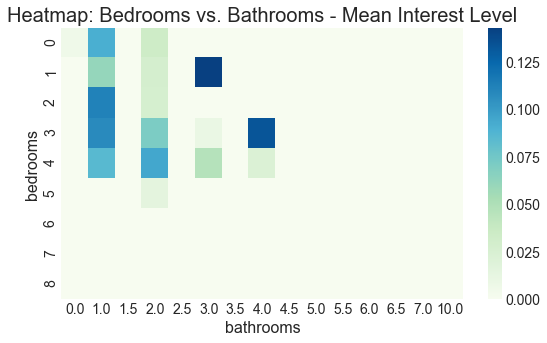

In [79]:
rooms['interest_level_int_v3'] = rooms['interest_level'].apply(lambda x: get_ilevel_int(x, [0,0,1]))

bedbath_mean_ilvl = rooms.drop(12089).groupby(['bedrooms','bathrooms'])['interest_level_int_v3'].mean().unstack().fillna(0)

plt.figure(figsize=(9,5))

ax = sns.heatmap(bedbath_mean_ilvl, cmap='GnBu')

ax.set_title('Heatmap: Bedrooms vs. Bathrooms - Mean Interest Level')

directory = 'figures'
file_name = 'Room Analysis_Heatmap_Bed Bath Interest Mean v2.png'
plt.savefig(path.join(directory, file_name))

plt.show()

In [81]:
mean_ilvl = rooms['interest_level_int_v3'].mean()
print('Mean Interest Level = {:.2f}'.format(mean_ilvl))

Mean Interest Level = 0.08


Slightly different intensities since fewer positive additions withou the 0.5 from medium interest, but the same combinations are highlighted as being above average.